In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import utils
from scipy.optimize import least_squares, curve_fit
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from DataLoader import DataLoader
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [3]:
def vix2(ivolData, expiry: int):
    df = ivolData[ivolData['Expiry'] == expiry]
    texp = df['Texp'].values[0]
    mask = ~df['Bid'].isna()
    df = df.loc[mask]

    midVol = 0.5 * (df['Ask'] + df['Bid'])
    fwd = df['Fwd'].values[0]  # Forward price
    strikes = df['Strike']
    k = np.log(strikes / fwd).values  # Log-moneyness
    kmin, kmax = min(k), max(k)
    minvo, maxvo = midVol[k == kmin].values[0], midVol[k == kmax].values[0]

    def volInterp(kout):
        """
        Interpolate vol between strikes;
        set constant outside strike range, use Stineman inside
        """
        if not isinstance(kout, np.ndarray):
            kout = np.array([kout])
        return np.where(
            kout < kmin, minvo,
            np.where(
                kout > kmax, maxvo,
                utils.stineman_interp(k, midVol.values, kout)
            )
        )
    
    # Integrand functions for calls and puts
    def cTilde(y):
        K = np.exp(y)
        vol = volInterp(y)
        price = utils.BSFormula(S=1., K=K, t=texp, r=0, vol=vol, callPutFlag=1)
        return np.exp(y) * price
    
    def pTilde(y):
        K = np.exp(y)
        vol = volInterp(y)
        price = utils.BSFormula(S=1., K=K, t=texp, r=0, vol=vol, callPutFlag=0)
        return np.exp(y) * price
    
    
    # Compute the integrals
    callIntegral, _ = quad(cTilde, 0, 10)
    putIntegral, _ = quad(pTilde, -10, 0)
    
    # Calculate the result
    # res = fwd ** 2 + 2 * (callIntegral + putIntegral)
    res = fwd ** 2 * (1 + 2 * (callIntegral + putIntegral))
    return res


def vix4(ivolData, expiry: int):
    df = ivolData[ivolData['Expiry'] == expiry]
    texp = df['Texp'].values[0]
    mask = ~df['Bid'].isna()
    df = df.loc[mask]

    midVol = 0.5 * (df['Ask'] + df['Bid'])
    fwd = df['Fwd'].values[0]  # Forward price
    strikes = df['Strike']
    k = np.log(strikes / fwd).values  # Log-moneyness
    kmin, kmax = min(k), max(k)
    minvo, maxvo = midVol[k == kmin].values[0], midVol[k == kmax].values[0]

    def volInterp(kout):
        """
        Interpolate vol between strikes;
        set constant outside strike range, use Stineman inside
        """
        if not isinstance(kout, np.ndarray):
            kout = np.array([kout])
        return np.where(
            kout < kmin, minvo,
            np.where(
                kout > kmax, maxvo,
                utils.stineman_interp(k, midVol.values, kout)
            )
        )
    
    # Integrand functions for calls and puts
    def cTilde(y):
        K = np.exp(y)
        vol = volInterp(y)
        price = utils.BSFormula(S=1., K=K, t=texp, r=0, vol=vol, callPutFlag=1)
        return np.exp(3*y) * price
    
    def pTilde(y):
        K = np.exp(y)
        vol = volInterp(y)
        price = utils.BSFormula(S=1., K=K, t=texp, r=0, vol=vol, callPutFlag=0)
        return np.exp(3*y) * price
    
    
    # Compute the integrals
    callIntegral, _ = quad(cTilde, 0, 10)
    putIntegral, _ = quad(pTilde, -10, 0)
    
    # Calculate the result
    # res = fwd ** 2 + 2 * (callIntegral + putIntegral)
    res = fwd ** 4 * (1 + 12 * (callIntegral + putIntegral))
    return res

In [4]:
def sigma_market(ivol_data, expiry: int):
    exp_vix2_mkt = vix2(ivol_data, expiry=expiry) * utils.DELTA / 10**4
    exp_vix4_mkt = vix4(ivol_data, expiry=expiry) * utils.DELTA**2 / 10**8
    return utils.sigma_lognormal(exp_vix2_mkt, exp_vix4_mkt)

def sigma_jacquier(curve: utils.VarianceCurve, volvol: float, hurst: utils.Hurst, T: float):
    exp_vix2_jac = utils.expected_vix_sq(curve)
    exp_vix4_jac = utils.moment2_vix_sq(curve, delta=utils.DELTA, volvol=volvol, hurst=hurst, T=T)
    return utils.sigma_lognormal(exp_vix2_jac, exp_vix4_jac)

def sigma_jim(texp, eta: float, hurst: utils.Hurst):
    return eta**2 * texp**hurst.h2 * utils.f_supH(utils.DELTA / texp, hurst)

In [5]:
def _const_curve(t):
    return np.full(len(t), .234**2) if isinstance(t, np.ndarray) else .234**2

xi_1 = utils.VarianceCurve(_const_curve)

# One day example

In [23]:
loader = DataLoader("./data", "csv")
df = loader.load_dates("20060313", "20060314").to_pandas().set_index('Date')

In [25]:
# Parameters
H = utils.Hurst(0.07)
eta = 1.9
volvol = eta * np.sqrt(H.h2) / (utils.c_h(H) * 2)

In [40]:
single_texp = df.groupby('Texp')['Texp'].count()
single_texp = set(single_texp[single_texp == 1].index)
df = df[~df['Texp'].isin(single_texp)]

In [43]:
exp_dates = df['Expiry'].unique()
texp_array = df['Texp'].unique()

In [41]:
df

,,Expiry,Texp,Strike,Bid,Ask,Fwd,CallMid,r,C_Bid,C_Ask,P_Bid,P_Ask
Date,,,,,,,,,,,,,
2006-03-13,7,20060419,0.101256,12.5,0.481478,0.545418,12.863623,1.075,0.099277,0.95,1.20,0.60,0.7
2006-03-13,8,20060419,0.101256,15.0,0.629670,0.775962,12.863623,0.450,0.099277,0.35,0.55,2.40,2.7
2006-03-13,9,20060419,0.101256,17.5,0.792094,0.942133,12.863623,0.275,0.099277,0.20,0.35,4.70,5.0
2006-03-13,10,20060419,0.101256,20.0,0.945923,1.075015,12.863623,0.200,0.099277,0.15,0.25,7.10,7.5
2006-03-13,11,20060517,0.177968,10.0,0.442042,0.629150,13.480003,3.550,0.000004,3.40,3.70,0.05,0.2
2006-03-13,12,20060517,0.177968,12.5,0.539144,0.611752,13.480003,1.850,0.000004,1.80,1.90,0.75,0.9
2006-03-13,13,20060517,0.177968,15.0,0.646151,0.691496,13.480003,0.950,0.000004,0.90,1.00,2.30,2.6
2006-03-13,14,20060517,0.177968,17.5,0.719405,0.853278,13.480003,0.625,0.000004,0.50,0.75,4.40,4.8
2006-03-13,15,20060517,0.177968,20.0,0.697455,0.883202,13.480003,0.325,0.000004,0.20,0.45,6.70,7.1


In [44]:
sigma = np.array([
    sigma_market(df, exp) for exp in exp_dates
])

In [10]:
# def calibration(texps, h, nu):
#     hurst = utils.Hurst(h)

#     sigma_model = np.array([
#         sigma_jacquier(xi_1, nu, hurst, texp) for texp in texps
#     ])
#     return sigma_model


# def calibration_h(texps, h):
#     hurst = utils.Hurst(h)

#     sigma_model = np.array([
#         sigma_jacquier(xi_1, volvol, hurst, texp) for texp in texps
#     ])
#     return sigma_model

In [11]:
def calibration_jim(texps, h, _eta):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        sigma_jim(texp, _eta, hurst) for texp in texps
    ])
    return sigma_model


def calibration_h_jim(texps, h):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        sigma_jim(texp, eta, hurst) for texp in texps
    ])
    return sigma_model

In [12]:
params, _ = curve_fit(
    calibration_jim, texp_array, sigma,
    p0=[0.07, eta],
    bounds=([0., 0.], [1., np.inf])
)

In [13]:
params_h, _ = curve_fit(
    calibration_h_jim, texp_array, sigma,
    p0=[0.07],
    bounds=(0., 1.)
)

In [14]:
print(params)
print([params_h.item(), eta])

[0.00854008 6.80837638]
[0.22167257984389474, 1.9]


In [15]:
sigma_joint = calibration_jim(texp_array, *params)
sigma_h = calibration_h_jim(texp_array, params_h.item())
sigma_hat_0 = calibration_jim(texp_array, H.h, eta)

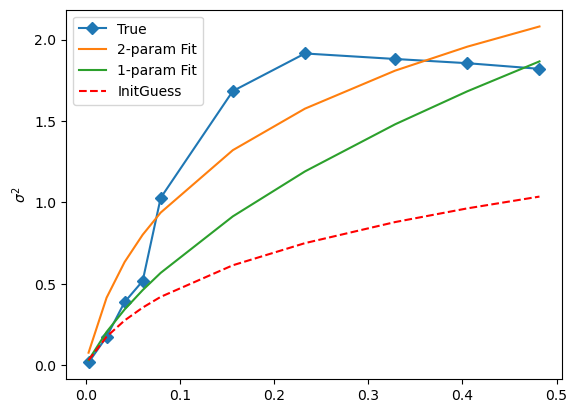

In [18]:
plt.plot(texp_array, sigma, marker='D', label='True', color='C0')
plt.plot(texp_array, sigma_joint, label='2-param Fit', color='C1')
plt.plot(texp_array, sigma_h, label='1-param Fit', color='C2')
plt.plot(texp_array, sigma_hat_0, color='red', ls='--', label='InitGuess')
plt.ylabel(r"$\sigma^2$")
plt.legend()
plt.show()

In [20]:
[r2_score(sigma, pred) for pred in (sigma_joint, sigma_h)]

[0.9031053857510027, 0.7259560461363841]

# Everyday I'm hustling

In [6]:
start, end = "20060224", "20100101"

In [7]:
loader = DataLoader("./data", "csv")
df = loader.load_dates(start, end).sort('Date')[:, 1:]

In [8]:
dates = df['Date'].unique().to_list()

In [9]:
# Parameters
H = utils.Hurst(0.07)
eta = 1.9
volvol = eta * np.sqrt(H.h2) / (utils.c_h(H) * 2)

def calibration_jim(texps, h, _eta):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        sigma_jim(texp, _eta, hurst) for texp in texps
    ])
    return sigma_model


def calibration_h_jim(texps, h):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        sigma_jim(texp, eta, hurst) for texp in texps
    ])
    return sigma_model

In [10]:
def calibrate_one_day(dd):
    _df = df.filter(pl.col('Date') == dd).to_pandas().set_index('Date')
    if _df.empty:
        return np.array([np.nan, np.nan])
    # address expirations with single obs
    single_texp = _df.groupby('Texp')['Texp'].count()
    single_texp = set(single_texp[single_texp == 1].index)
    _df = _df[~_df['Texp'].isin(single_texp)]
    
    exp_dates = _df['Expiry'].unique()
    texp_array = _df['Texp'].unique()

    # true values
    sigma = np.array([
        sigma_market(_df, exp) for exp in exp_dates
    ])

    # calibrate - we try 2-parameter calibration and if it fails
    # we just fit H
    try:
        params, _ = curve_fit(
            calibration_jim, texp_array, sigma,
            p0=[0.07, eta],
            bounds=([0., 0.], [1., np.inf])
        )
    except:
        params, _ = curve_fit(
            calibration_h_jim, texp_array, sigma,
            p0=[0.07],
            bounds=(0., 1.)
        )
        params = np.concatenate((params, [np.nan]))
    
    return params
    

In [11]:
calibrated_params = []  # [calibrate_one_day(dd) for dd in tqdm(dates)]
for dd in tqdm(dates):
    try:
        calibrated_params.append(calibrate_one_day(dd))
    except IndexError:
        calibrated_params.append([np.nan, np.nan])
        print(dd, dd, dd)

100%|██████████| 971/971 [22:40<00:00,  1.40s/it]


In [12]:
params = pd.DataFrame(calibrated_params, columns=['H', 'eta'], index=dates)
params.describe()

,H,eta
count,971.000000,585.000000
mean,0.108411,1.692268
std,0.091115,0.958472
min,0.001652,1.020791
25%,0.042774,1.246258
50%,0.067401,1.426727
75%,0.165068,1.676202
max,1.000000,9.144116


In [13]:
params = pd.DataFrame(calibrated_params, columns=['H', 'eta'], index=dates)
params.describe()

,H,eta
count,971.000000,585.000000
mean,0.108411,1.692268
std,0.091115,0.958472
min,0.001652,1.020791
25%,0.042774,1.246258
50%,0.067401,1.426727
75%,0.165068,1.676202
max,1.000000,9.144116


In [17]:
params.fillna(eta).describe()

,H,eta
count,971.000000,971.000000
mean,0.108411,1.774847
std,0.091115,0.750627
min,0.001652,1.020791
25%,0.042774,1.367249
50%,0.067401,1.899788
75%,0.165068,1.900000
max,1.000000,9.144116


In [18]:
params.dropna().describe()

,H,eta
count,585.000000,585.000000
mean,0.147601,1.692268
std,0.098832,0.958472
min,0.001652,1.020791
25%,0.070390,1.246258
50%,0.141795,1.426727
75%,0.212551,1.676202
max,1.000000,9.144116


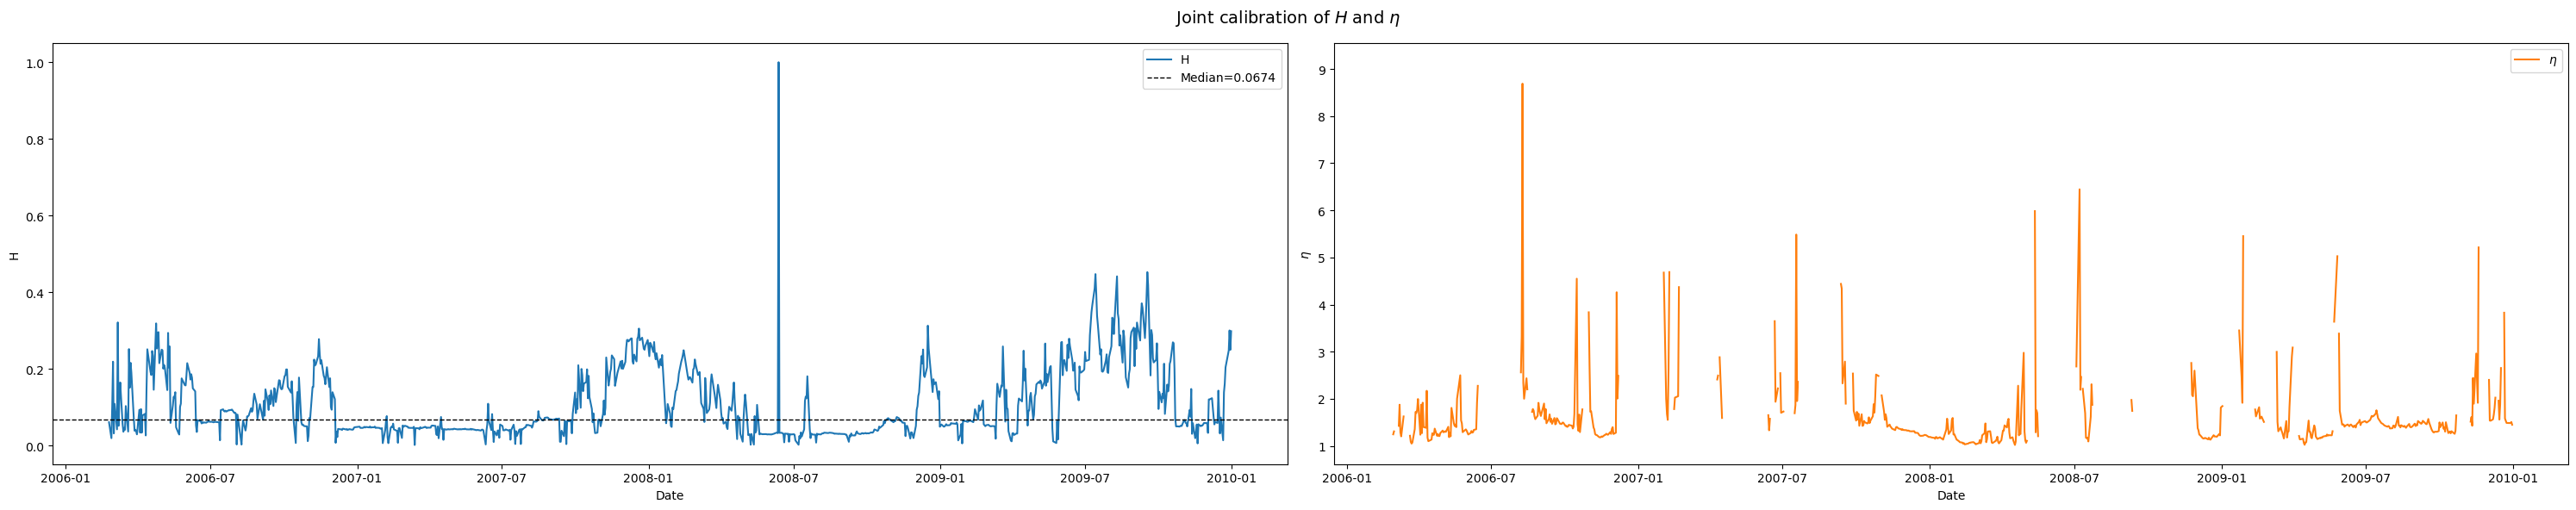

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params['H'], label='H', color='C0')
axs[0].axhline(params['H'].median(), ls='--', color='black', lw=1, label=f'Median={params["H"].median():.4f}')
axs[1].plot(params['eta'], label=r'$\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")

fig.tight_layout()
plt.savefig(f"./Plots/calibrated_params_{start}_{end}.png")
plt.show()

In [15]:
params.to_parquet(f"params_{start}_{end}.parquet")